In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_cw(model, test_loader, targeted=False, c=0.75, alpha=0.01, kappa= 0, max_iterations=50, mnist = 1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        target = 3
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            
            advimages = cw_attack(image, model, init_pred, targeted, 3, c, alpha, kappa, max_iterations)
            output_adv, _ = model(advimages)
            # advimages = advimages[0,:,:,:] / 255

            #print(advimages.shape)
            #viz.show(advimages.detach())
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
            
                if not targeted: 
                    #if prediction_adv not in pred_list:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    
                    #if not mnist:
                        #adv_ex = adv_ex/255
                    
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                    pred_list.append(prediction_adv)
                else:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  

            if total-correct > 100:
                break
            
        
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, mnist = 1)

0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
2 / 6
2 / 7
2 / 8
2 / 9
2 / 10
2 / 11
2 / 12
2 / 13
2 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
4 / 21
4 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
5 / 30
5 / 31
6 / 32
6 / 33
6 / 34
6 / 35
6 / 36
6 / 37
7 / 38
7 / 39
8 / 40
9 / 41
9 / 42
9 / 43
9 / 44
9 / 45
9 / 46
10 / 47
10 / 48
10 / 49
10 / 50
10 / 51
10 / 52
10 / 53
10 / 54
10 / 55
10 / 56
10 / 57
11 / 58
11 / 59
11 / 60
11 / 61
12 / 62
12 / 63
12 / 64
12 / 65
12 / 66
12 / 67
12 / 68
12 / 69
12 / 70
12 / 71
12 / 72
12 / 73
12 / 74
13 / 75
13 / 76
13 / 77
13 / 78
13 / 79
13 / 80
13 / 81
13 / 82
13 / 83
13 / 84
13 / 85
13 / 86
13 / 87
13 / 88
13 / 89
14 / 90
14 / 91
14 / 92
14 / 93
14 / 94
15 / 95
15 / 96
16 / 97
16 / 98
16 / 99
16 / 100
16 / 101
16 / 102
16 / 103
16 / 104
16 / 105
16 / 106
16 / 107
17 / 108
17 / 109
17 / 110
18 / 111
18 / 112
18 / 113
18 / 114
18 / 115
18 / 116
18 / 117
18 / 118
18 / 119
Accuracy of test text: 15.126050 %


101


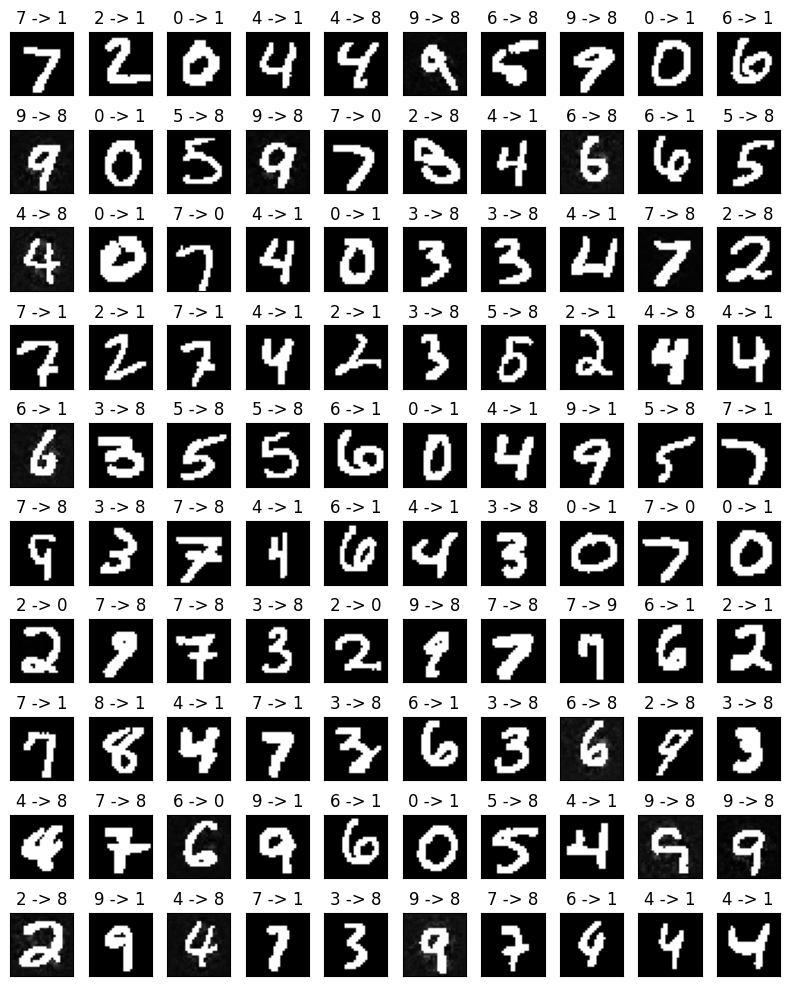

In [9]:
num_cols = len(adv_examples)
print(num_cols)

# fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))  # Adjust figsize as needed
# for i in range(num_cols):
#     true_label, false_label, image_data = adv_examples[i]
    
#     true_label = true_label.item()
#     false_label = false_label.item()
    
#     axes[i].imshow(image_data, cmap='gray')  # Assuming the image is grayscale, adjust cmap as needed
#     title = f"{true_label} -> {false_label}"
#     axes[i].set_title(title)
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
2 / 6
2 / 7
3 / 8
4 / 9
4 / 10
4 / 11
4 / 12
4 / 13
5 / 14
5 / 15
5 / 16
6 / 17
6 / 18
6 / 19
6 / 20
6 / 21
6 / 22
7 / 23
7 / 24
7 / 25
7 / 26
7 / 27
8 / 28
8 / 29
8 / 30
8 / 31
8 / 32
8 / 33
8 / 34
8 / 35
9 / 36
9 / 37
10 / 38
11 / 39
11 / 40
11 / 41
12 / 42
12 / 43
12 / 44
12 / 45
12 / 46
13 / 47
13 / 48
13 / 49
13 / 50
13 / 51
14 / 52
14 / 53
15 / 54
15 / 55
15 / 56
16 / 57
16 / 58
17 / 59
17 / 60
17 / 61
17 / 62
17 / 63
17 / 64
18 / 65
18 / 66
18 / 67
18 / 68
18 / 69
18 / 70
18 / 71
18 / 72
19 / 73
20 / 74
20 / 75
20 / 76
20 / 77
20 / 78
20 / 79
21 / 80
21 / 81
22 / 82
22 / 83
23 / 84
23 / 85
24 / 86
24 / 87
25 / 88
25 / 89
26 / 90
26 / 91
26 / 92
26 / 93
26 / 94
26 / 95
26 / 96
26 / 97
27 / 98
27 / 99
27 / 100
27 / 101
27 / 102
27 / 103
27 / 104
27 / 105
27 / 106
27 / 107
28 / 108
28 / 109
28 / 110
28 / 111
28 / 112
28 / 113
28 / 114
28 / 115
28 / 116
28 / 117
28 / 118
28 / 119
28 / 120
28 / 121
28 / 122
29 / 123
29 / 124
30 / 125
30 / 126
30 / 127
30

[[[0.72265565 0.7226593  0.7226593  ... 0.72266614 0.72266924 0.7226593 ]
  [0.7226593  0.7226593  0.7226593  ... 0.72266614 0.7226722  0.7226593 ]
  [0.72265565 0.7226517  0.7226593  ... 0.7226722  0.7226722  0.7226593 ]
  ...
  [0.7226941  0.72269607 0.722692   ... 0.72267514 0.72267514 0.72266614]
  [0.7226899  0.722692   0.7226877  ... 0.72267514 0.7226778  0.72266924]
  [0.72268546 0.72268546 0.7226805  ... 0.7226722  0.72267514 0.72266924]]

 [[0.72274524 0.7227457  0.7227457  ... 0.7227447  0.72274524 0.722742  ]
  [0.7227457  0.7227457  0.7227457  ... 0.7227447  0.72274417 0.722742  ]
  [0.72274625 0.7227457  0.72274673 ... 0.72274417 0.72274363 0.722742  ]
  ...
  [0.7227522  0.7227526  0.7227518  ... 0.7227518  0.72275144 0.72275025]
  [0.72275144 0.7227518  0.722751   ... 0.72275144 0.722751   0.7227498 ]
  [0.7227506  0.7227506  0.7227498  ... 0.722751   0.7227506  0.7227498 ]]

 [[0.72270787 0.72270936 0.72271085 ... 0.72270936 0.72271085 0.72270316]
  [0.72270936 0.722709

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


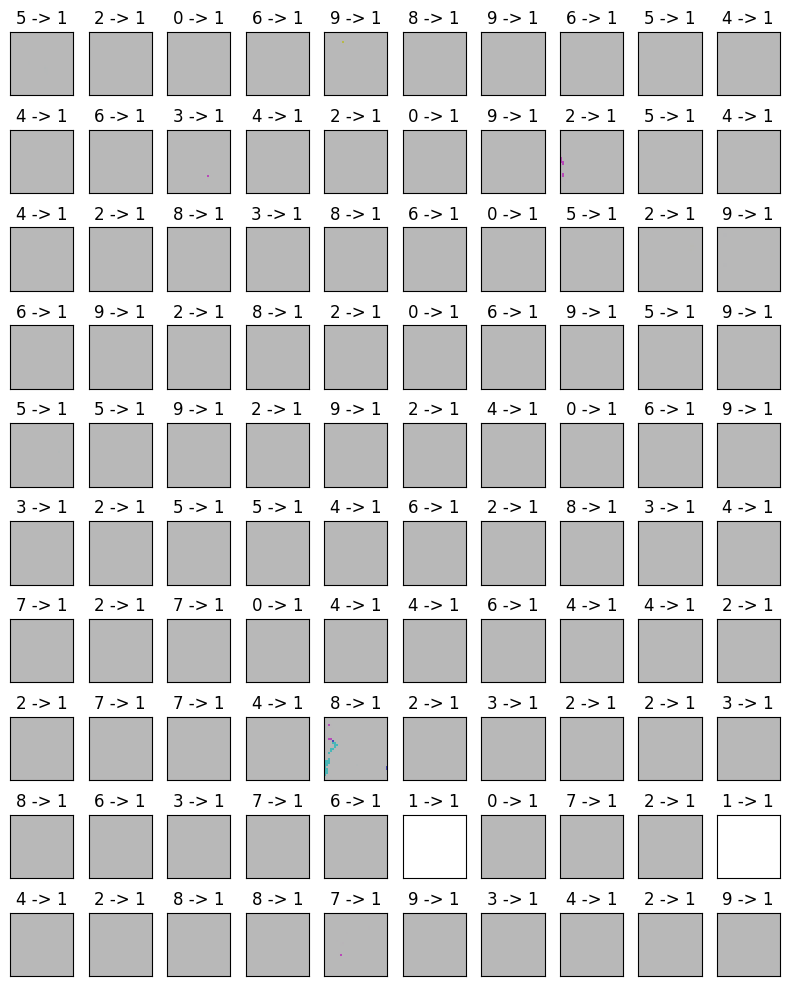

In [11]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}



# for img in adv_examples:
#     print(label_mapping2[img[0].item()])
#     print(label_mapping2[img[1].item()])
#     image = img[2] 
#     viz.show(image)

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [12]:
adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, mnist = 0)

1 / 1
1 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
2 / 13
2 / 14
2 / 15
2 / 16
2 / 17
2 / 18
2 / 19
2 / 20
2 / 21
2 / 22
2 / 23
2 / 24
2 / 25
2 / 26
2 / 27
2 / 28
2 / 29
2 / 30
2 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
2 / 38
2 / 39
2 / 40
2 / 41
2 / 42
2 / 43
2 / 44
2 / 45
2 / 46
3 / 47
3 / 48
3 / 49
3 / 50
3 / 51
3 / 52
3 / 53
4 / 54
4 / 55
4 / 56
4 / 57
4 / 58
4 / 59
4 / 60
4 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
8 / 78
9 / 79
9 / 80
9 / 81
9 / 82
9 / 83
9 / 84
9 / 85
9 / 86
9 / 87
9 / 88
9 / 89
9 / 90
9 / 91
10 / 92
10 / 93
10 / 94
10 / 95
10 / 96
10 / 97
10 / 98
10 / 99
10 / 100
10 / 101
10 / 102
10 / 103
11 / 104
11 / 105
11 / 106
12 / 107
12 / 108
12 / 109
12 / 110
12 / 111
12 / 112
12 / 113
Accuracy of test text: 10.619469 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.72277427 0.72277385 0.7227739  ... 0.722774   0.722774   0.7227739 ]
  [0.7227745  0.72277427 0.72277427 ... 0.7227744  0.7227744  0.72277427]
  [0.72277445 0.72277415 0.72277415 ... 0.72277427 0.72277427 0.72277415]
  ...
  [0.7227357  0.7226722  0.72251    ... 0.72276545 0.7227677  0.7227686 ]
  [0.72273195 0.7226805  0.72264767 ... 0.72276634 0.7227682  0.7227685 ]
  [0.7227343  0.72271085 0.72270477 ... 0.7227652  0.72276735 0.72276825]]

 [[0.72277427 0.72277385 0.7227739  ... 0.722774   0.722774   0.7227739 ]
  [0.7227745  0.72277427 0.72277427 ... 0.7227744  0.7227744  0.72277427]
  [0.72277445 0.72277415 0.72277415 ... 0.72277427 0.72277427 0.72277415]
  ...
  [0.72274315 0.722692   0.7225612  ... 0.72276795 0.7227699  0.7227706 ]
  [0.7227414  0.72270316 0.72267514 ... 0.7227688  0.7227703  0.7227706 ]
  [0.72274417 0.72272587 0.7227172  ... 0.72276783 0.7227696  0.7227703 ]]

 [[0.72277427 0.72277385 0.7227739  ... 0.722774   0.722774   0.7227739 ]
  [0.7227745  0.722774

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


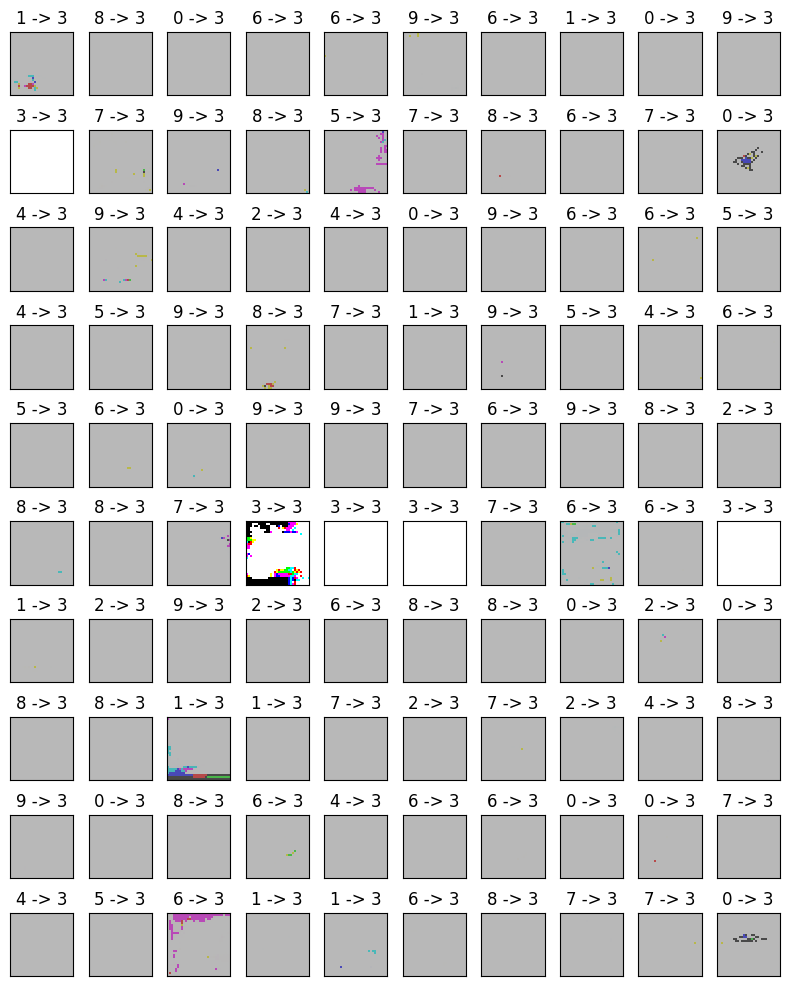

In [13]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
# for img in adv_examples:
#     print(label_mapping[img[0].item()])
#     print(label_mapping[img[1].item()])
#     image = img[2]
#     viz.show(image)

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()